# Computing Expected Improvement with a Parametric Mean Field Assumption
## What I Need to Do
- [ ] Write a solver for computing the optimal hyperparameters of our model
- [ ] Update logic on computing log determinant for hyperparameters

Uninformative prior limit stuff literature

## Questions
- It still isn't clear to me how we compute the log determinant of our KKT-like system. In the limiting case of the uninformative prior, we have block zero entries in our linear system which seem to push the determinant to 0. 

In [142]:
using Profile
using ProfileView
using Polynomials

All the necessary imports for our computations of interest

In [143]:
include("../bayesian_optimization.jl")
plotlyjs()

Plots.PlotlyJSBackend()

## Basic Setup

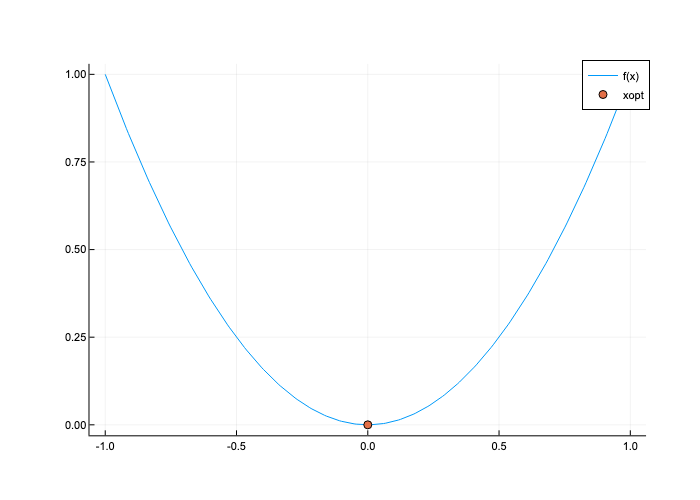

In [148]:
# Visualize 1D test function
testfn = TestQuadratic1D()
# testfn = TestRosenbrock()
tplot(testfn)

In [149]:
lbs, ubs = get_bounds(testfn)
domain = lbs[1]:.01:ubs[1]

-1.0:0.01:1.0

In [161]:
kernel = SquaredExponential()
polynomial = PolynomialBasisFunction([
        x -> 1., x -> first(x) ^ 2,
])
N = 18
observation_noise = 1e-8
X = randsample(N, testfn.dim, lbs, ubs)
y = testfn(X) + observation_noise * randn(N)

hsur = HybridSurrogate(kernel, polynomial, X, y, decision_rule=EI(),
    observation_noise=observation_noise, capacity=N)
sur = Surrogate(kernel, X, y, decision_rule=EI(),
    observation_noise=observation_noise, capacity=N);

In [162]:
Z, Y = X[:, 1:2], X[:, 3:end]
lz, ly = size(Z, 2), size(Y, 2)

KZ, KY, KX = eval_KXX(kernel, Z), eval_KXX(kernel, Y), eval_KXX(kernel, X)
KZ += observation_noise * I
KY += observation_noise * I
KZY = eval_KXY(kernel, Z, Y)

PZ, PY, PX = eval_basis(polynomial, Z), eval_basis(polynomial, Y), eval_basis(polynomial, X)
zz = zeros(length(polynomial), length(polynomial))
y1, y2 = y[1:lz], y[lz+1:end]

M = [KZ   KZY PZ;
     KZY' KY  PY;
     PZ'  PY' zz]
coefficients = lu(M) \ [y1; y2; zeros(length(polynomial))]
d, λ = coefficients[1:N], coefficients[N+1:end]
coefficients

20-element Vector{Float64}:
  1.794157392664889
 -0.04439854643350184
  0.41955710856603284
 -0.8144025646851881
 -0.050480287979902866
 -0.02784558918765068
 -2.434508897519995
  1.066305249865583
 -0.433323476255875
 -1.084040394809829
 -0.8074232721881747
 -0.23328414795364003
  0.6265621431510652
  0.9315237323234706
 -0.6520032484587496
 -0.11129111455263378
  0.9576079731284087
  0.8972879403256904
  1.1470732230591206e-5
  0.9999913440125684

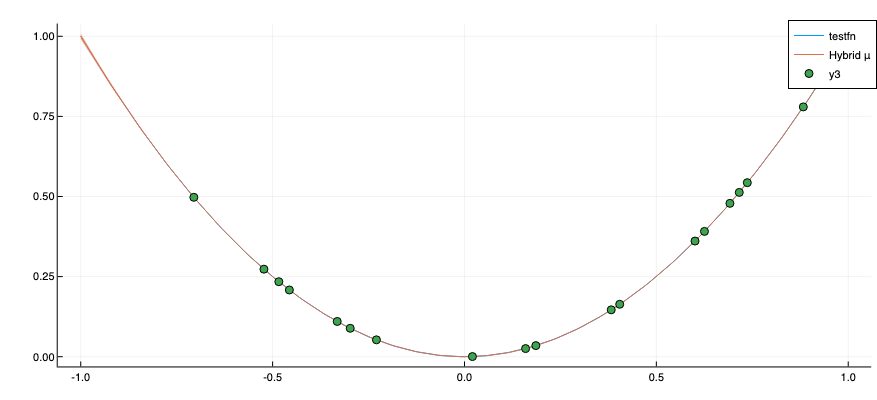

In [163]:
domain = lbs[1]:.01:ubs[1]
μ = similar(domain) # Predictive mean for standard model: f(x) ~ Z(x)
μ2 = similar(domain) # Predictive mean for the hybrid model: f(x) ~ P(x)c + Z(x)
∇μ2 = similar(domain)
Hμ2 = similar(domain)
σ = similar(domain)
σ2 = similar(domain)
∇σ2 = similar(domain)
Hσ2 = similar(domain)
EIx = similar(domain)
EIx2 = similar(domain)

for (i, x) in enumerate(domain)
    sx = sur([x], [0.])
    hsx = hsur([x], [0.])
    
    μ[i] = sx.μ
    μ2[i] = hsx.μ
    ∇μ2[i] = first(hsx.∇μ)
    Hμ2[i] = first(hsx.Hμ)
    σ[i] = sx.σ
    σ2[i] = hsx.σ
    ∇σ2[i] = first(hsx.∇σ)
    Hσ2[i] = first(hsx.Hσ)
    EIx[i] = eval(sx)
    EIx2[i] = eval(hsx)
end

plot(domain, [testfn([x]) for x in domain], label="testfn")
# plot!(domain, μ, ribbons=2σ, label="GP μ")
# plot!(domain, μ3, label="Other μ")
plot!(domain, μ2, ribbons=2σ2, label="Hybrid μ")
scatter!(get_active_covariates(hsur)', get_active_observations(sur))

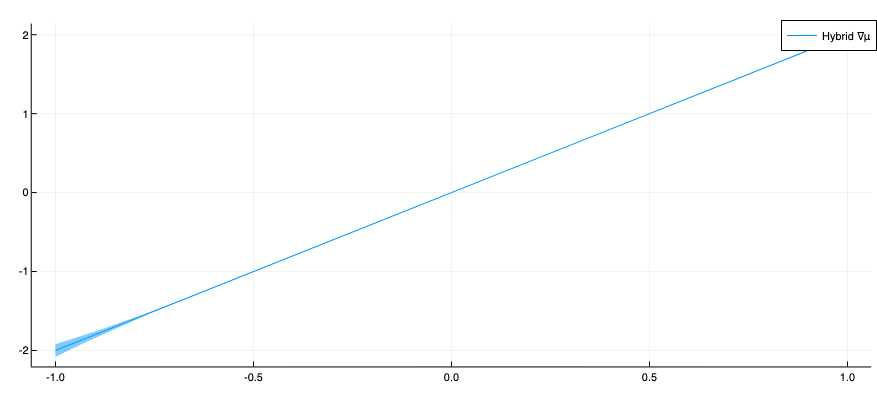

In [164]:
plot(domain, ∇μ2, ribbons=2∇σ2, label="Hybrid ∇μ")

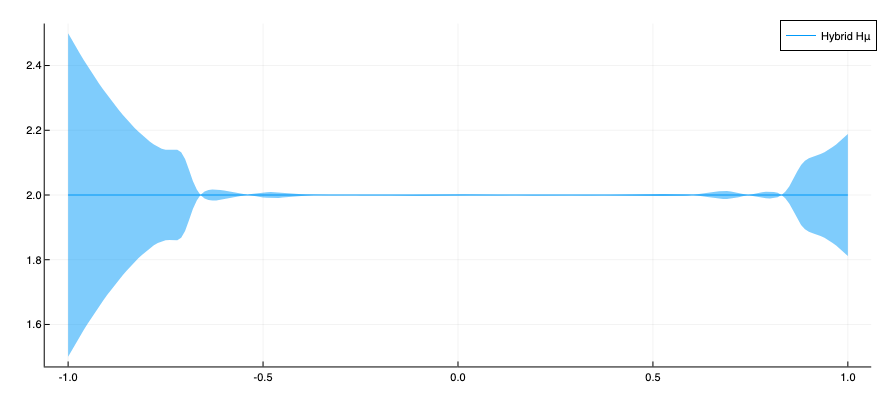

In [165]:
plot(domain, Hμ2, ribbons=2Hσ2, label="Hybrid Hμ")

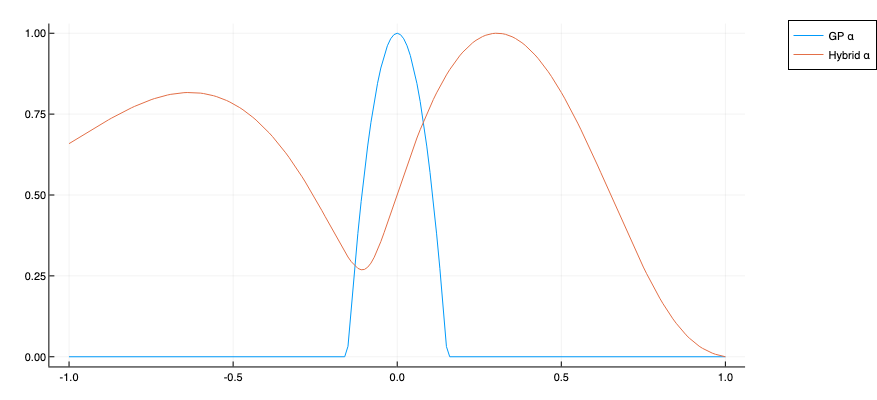

In [384]:
plot(domain, stdize(EIx), label="GP α")
plot!(domain, stdize(EIx2), label="Hybrid α", legend=:outertopright)
# plot!(domain, stdize(POIx), label="Probability of Improvement")
# plot!(domain, stdize(LCBx), label="Lower Confidence Bound")

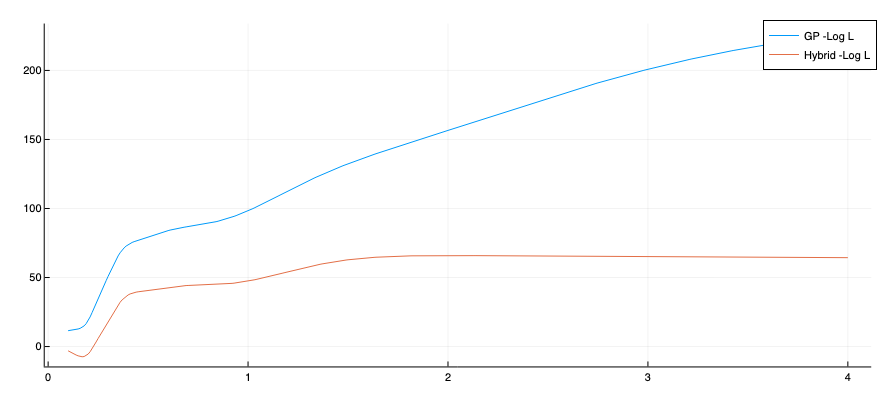

In [94]:
hyperparameter_grid = .1:.01:4.
results = similar(hyperparameter_grid)
results_hybrid = similar(hyperparameter_grid)

for (i, hyperparameter) in enumerate(hyperparameter_grid)
    set_kernel!(
        sur,
        set_hyperparameters!(
            get_kernel(sur),
            [hyperparameter]
        )
    )
    set_kernel!(
        hsur,
        set_hyperparameters!(
            get_kernel(hsur),
            [hyperparameter]
        )
    )
    results_hybrid[i] = log_likelihood(hsur)
    results[i] = log_likelihood(sur)
end

plot(hyperparameter_grid, -results, label="GP -Log L")
plot!(hyperparameter_grid, -results_hybrid, label="Hybrid -Log L")